<a href="https://colab.research.google.com/github/M-Waweru/DengueChallenge/blob/master/Obituaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install lifelines


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import datetime as dt
from lifelines import KaplanMeierFitter


%matplotlib inline

In [44]:
# When using Colab, run the code below to load csv

from google.colab import drive
drive.mount('/content/gdrive')

path = "/content/gdrive/My Drive/Colab Notebooks/Obituaries/Obituaries_Dataset.csv"
obituaries_df = pd.read_csv(path)

# When running locally
# obituaries_df = pd.read_csv('Obituaries_Dataset.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [45]:
obituaries_df.head()

,Name,Announcement,Death,Burial,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Fundraising,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Distance_Death,Distance_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue,Same_Morgue,Cost_Morgue,Occupation,Repetition,Corporate,Corporate_Name,Residence,Residence_Name,Residence_Category
0,Eng. Paul Chemweno,11/8/2017,11/2/2017,11/17/2017,Friday,Weekday,Male,66.0,Yes,55.18,179,7.0,0.0,0.0,Yes,6,15,9,35,Uasin Gishu,Uasin Gishu,Uasin Gishu,0,0,illness,Yes,Yes,Female,Memorial Hospital Eldoret,MTRH Eldoret,No,NaN,Director,NaN,NaN,NaN,NaN,NaN,NaN
1,Edith Kiende Kiogora,11/8/2017,10/27/2017,11/11/2017,Saturday,Weekend,Female,43.0,Yes,83.60,293,4.0,0.0,7.0,Yes,12,15,3,8,Tharaka Nithi,Nairobi,Tharaka Nithi,224,0,illness,Yes,Yes,Male,Nairobi West Hospital,Chogoria Hospital Mortuary,No,NaN,Teacher,NaN,NaN,NaN,NaN,NaN,NaN
2,Simon Muchiri Ngigii Mbaria,11/8/2017,11/1/2017,11/8/2017,Wednesday,Weekday,Male,35.0,Yes,109.12,206,4.0,0.0,2.0,No,7,7,0,7,Nyandarua,Nyandarua,Nakuru,0,77,illness,Yes,Yes,Female,Charity Hospital Nyahururu,Umash Nakuru,No,NaN,Teacher,NaN,NaN,NaN,NaN,NaN,NaN
3,Mwalimu Erick Namusasi Werunga,11/8/2017,10/24/2017,11/9/2017,Thursday,Weekday,Male,54.0,Yes,83.60,171,4.0,0.0,0.0,No,15,16,1,33,Trans Nzioa,NaN,Trans Nzioa,0,NaN,illness,Yes,No,Female,NaN,Maida Mortuary,NaN,NaN,Teacher,NaN,NaN,NaN,NaN,NaN,NaN
4,Catherine Mueni Sina,11/8/2017,11/2/2017,11/11/2017,Saturday,Weekend,Female,41.0,No,55.18,150,1.0,0.0,NaN,NaN,6,9,3,17,Machakos,Uasin Gishu,NaN,378,NaN,accident,NaN,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

In [46]:
obituaries_df.columns

Index(['Name', 'Announcement', 'Death', 'Burial', 'Burial_Day', 'Burial_Week',
       'Gender', 'Age', 'Color', 'Size', 'Word_Count', 'No_of_Children',
       'Significant_Children', 'Significant_Relatives', 'Fundraising',
       'Death_to_Announce', 'Death_to_Burial', 'Announce_to_Burial',
       'No_of_Relatives', 'County_Burial', 'County_Death', 'County_Morgue',
       'Distance_Death', 'Distance_Morgue', 'Cause_of_Death', 'Married',
       'Spouse_Alive', 'Spouse_gender', 'Hospital', 'Morgue', 'Same_Morgue',
       'Cost_Morgue', 'Occupation', 'Repetition', 'Corporate',
       'Corporate_Name', 'Residence', 'Residence_Name', 'Residence_Category'],
      dtype='object')

In [47]:
obituaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 39 columns):
Name                     1291 non-null object
Announcement             1265 non-null object
Death                    893 non-null object
Burial                   1164 non-null object
Burial_Day               1163 non-null object
Burial_Week              1163 non-null object
Gender                   1291 non-null object
Age                      507 non-null float64
Color                    1289 non-null object
Size                     1237 non-null float64
Word_Count               1237 non-null object
No_of_Children           1093 non-null float64
Significant_Children     1092 non-null float64
Significant_Relatives    1083 non-null float64
Fundraising              1142 non-null object
Death_to_Announce        1291 non-null object
Death_to_Burial          1244 non-null object
Announce_to_Burial       1278 non-null object
No_of_Relatives          1061 non-null object
County_Burial   

In [48]:
obituaries_df['Burial_Day'].value_counts()

Saturday     373
Friday       364
Thursday     137
Tuesday      111
Wednesday    101
Monday        50
Sunday        16
saturday      11
Name: Burial_Day, dtype: int64

In [49]:
obituaries_df['Burial_Day'].unique()

array(['Friday', 'Saturday', 'Wednesday', 'Thursday', 'Tuesday', 'Monday',
       nan, 'Sunday', 'saturday'], dtype=object)

In [50]:
pp.ProfileReport(obituaries_df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,39
Number of observations,1291
Total Missing (%),38.0%
Total size in memory,393.5 KiB
Average record size in memory,312.1 B
Numeric,5
Categorical,34
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [51]:
obituaries_df.isnull().sum()

Name                        0
Announcement               26
Death                     398
Burial                    127
Burial_Day                128
Burial_Week               128
Gender                      0
Age                       784
Color                       2
Size                       54
Word_Count                 54
No_of_Children            198
Significant_Children      199
Significant_Relatives     208
Fundraising               149
Death_to_Announce           0
Death_to_Burial            47
Announce_to_Burial         13
No_of_Relatives           230
County_Burial             247
County_Death              766
County_Morgue             411
Distance_Death            805
Distance_Morgue           420
Cause_of_Death            493
Married                   243
Spouse_Alive              348
Spouse_gender             356
Hospital                 1024
Morgue                    426
Same_Morgue              1088
Cost_Morgue              1289
Occupation               1040
Repetition

In [52]:
obituaries_df.duplicated().sum()

0

# Data Preparation and Analysis 

In [53]:
obituaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 39 columns):
Name                     1291 non-null object
Announcement             1265 non-null object
Death                    893 non-null object
Burial                   1164 non-null object
Burial_Day               1163 non-null object
Burial_Week              1163 non-null object
Gender                   1291 non-null object
Age                      507 non-null float64
Color                    1289 non-null object
Size                     1237 non-null float64
Word_Count               1237 non-null object
No_of_Children           1093 non-null float64
Significant_Children     1092 non-null float64
Significant_Relatives    1083 non-null float64
Fundraising              1142 non-null object
Death_to_Announce        1291 non-null object
Death_to_Burial          1244 non-null object
Announce_to_Burial       1278 non-null object
No_of_Relatives          1061 non-null object
County_Burial   

In [54]:
obituaries_df.sample(10)

,Name,Announcement,Death,Burial,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Fundraising,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Distance_Death,Distance_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue,Same_Morgue,Cost_Morgue,Occupation,Repetition,Corporate,Corporate_Name,Residence,Residence_Name,Residence_Category
421,Moses Kariuki Njoroge,3/15/2017,11/3/2017,3/16/2017,Thursday,Weekday,Male,39.0,Yes,56.07,160,0.0,0.0,6.0,No,#VALUE!,5,1,20,Nakuru,NaN,Nakuru,NaN,0,illness,No,NaN,NaN,NaN,St.Joseph Nursing Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1164,John Murathe Mutitu,3/21/2017,3/17/2017,NaN,NaN,NaN,Male,NaN,Yes,150.80,252,0.0,0.0,2.0,Yes,4,"-42,811","-42,815",14,Nairobi,Nairobi,Nairobi,0,0,illness,No,NaN,NaN,NaN,Montezuma Nairobi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397,Sophia Akinyi Agara Waeme,2/22/2017,NaN,2/25/2017,Saturday,Weekend,Female,NaN,Yes,56.07,128,2.0,0.0,0.0,No,#VALUE!,2/25/2017,3,17,Kakamega,NaN,Nairobi,NaN,395,illness,Yes,Yes,Male,NaN,Nairobi West Hospital Mortuary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
533,Alfred Arama Momanyi,3/28/2017,3/15/2017,3/31/2017,Friday,Weekday,Male,NaN,Yes,85.44,224,5.0,3.0,0.0,Yes,#VALUE!,16,3,58,Kisii,NaN,Nairobi,NaN,420,illness,Yes,Yes,Female,NaN,Umash Nairobi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766,Joseph Wandimi,4/8/2017,5/4/2017,11/4/2017,Thursday,Weekday,Male,72.0,yes,56.32,207,6.0,0.0,25.0,No,-26,3,6,3,Nyeri,NaN,Nairobi,NaN,151,illness,yes,Yes,Female,NaN,Kenyatta University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
824,Jane Syokwaa,5/18/2017,10/5/2017,5/19/2017,Friday,weekday,Female,75.0,yes,127.60,243,12.0,0.0,3.0,No,-140,8,9,1,Machakos,NaN,Machakos,NaN,0,NaN,yes,No,Male,NaN,Montezuma funeral home Machakos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,Solomon makuthi,4/8/2017,NaN,12/4/2017,Friday,Weekday,Male,47.0,yes,56.32,102,2.0,0.0,11.0,Yes,"42,833.00","42,833","42,837",4,Makueni,NaN,NaN,NaN,NaN,NaN,yes,Yes,Female,NaN,NaN,NaN,NaN,Accountant,NaN,NaN,Ministry of Tourism,NaN,NaN,NaN
1057,Eunice Nyang'endo Kuria,2/10/2017,NaN,2/14/2017,Tuesday,Weekday,Female,NaN,Yes,55.44,141,5.0,3.0,0.0,Yes,"42,776.00","42,780",4,10,Kiambu,Kiambu,Kiambu,0,0,illness,Yes,No,Male,NaN,Uplands Funeral Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
557,Agnes Agina Otieno,5/24/2017,NaN,5/27/2017,Saturday,Weekend,Female,NaN,Yes,85.44,165,8.0,0.0,0.0,No,#VALUE!,5/27/2017,3,25,Siaya,NaN,Siaya,NaN,0,illness,Yes,No,Male,NaN,Sagam Hospital Mortuary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
827,Florence Tirindi,5/18/2017,5/13/2017,5/19/2017,Friday,weekday,Female,NaN,yes,154.00,151,10.0,0.0,16.0,No,#VALUE!,5,6,1,Meru,NaN,Nairobi,NaN,319,NaN,yes,No,Male,NaN,Kenyatta University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Create copy for manipulation purposes
obituaries_copy_df = obituaries_df.copy()

In [56]:
obituaries_copy_df.columns

Index(['Name', 'Announcement', 'Death', 'Burial', 'Burial_Day', 'Burial_Week',
       'Gender', 'Age', 'Color', 'Size', 'Word_Count', 'No_of_Children',
       'Significant_Children', 'Significant_Relatives', 'Fundraising',
       'Death_to_Announce', 'Death_to_Burial', 'Announce_to_Burial',
       'No_of_Relatives', 'County_Burial', 'County_Death', 'County_Morgue',
       'Distance_Death', 'Distance_Morgue', 'Cause_of_Death', 'Married',
       'Spouse_Alive', 'Spouse_gender', 'Hospital', 'Morgue', 'Same_Morgue',
       'Cost_Morgue', 'Occupation', 'Repetition', 'Corporate',
       'Corporate_Name', 'Residence', 'Residence_Name', 'Residence_Category'],
      dtype='object')

In [0]:
# Columns to delete
columns_to_drop = ['Cost_Morgue', 'Occupation', 'Repetition', 'Corporate', 'Corporate_Name', 'Residence', 'Residence_Name', 'Residence_Category']

def deleteCols(df, cols):
  df.drop(columns=cols, inplace=True)
  return df

# Columns for dates to parse
columns_to_parse = ['Announcement', 'Death', 'Burial']

def parseTheDates(df, cols):
  for col in cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
  return df

# Columns to change from object to float
columns_to_float = ['Word_Count', 'Death_to_Announce', 'Death_to_Burial', 'Announce_to_Burial', 'No_of_Relatives',
                    'Distance_Death', 'Distance_Morgue']   

def changeDataTypes(df, cols):
  for col in cols:
    df.loc[df[col] == '#VALUE!', col] = np.nan 
    df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')
    print(col)
  return df

# changeDataTypes(obituaries_copy_df, ['Distance_Morgue']).sample(10)

# Sorting out issues in various columns
def fixColValues(df):
  df['Cause_of_Death'] = df['Cause_of_Death'].replace('Illness', 'illness')
  df['Cause_of_Death'] = df['Cause_of_Death'].replace('ilness', 'illness')
  df['Cause_of_Death'] = df['Cause_of_Death'].replace('Accident', 'accident')
  df['Burial_Day'] = df['Burial_Day'].replace('saturday', 'Saturday')
  df['Color'] = df['Color'].replace('yes', 'Yes')
  df['Color'] = df['Color'].replace('no', 'No')
  return df

# Recalculate days between announcement, death and burial
def recalculateCols(df):
  df['Death_to_Announce'] = (df['Announcement'] - df['Death']).dt.days

  df['Death_to_Burial'] = (df['Burial'] - df['Death']).dt.days

  df['Announce_to_Burial'] = (df['Burial'] - df['Announcement']).dt.days

  return df
 

In [58]:
# jhkjh
prepared_df = (obituaries_copy_df.pipe(deleteCols, cols=columns_to_drop)
                                .pipe(parseTheDates, cols=columns_to_parse)
                                .pipe(changeDataTypes, cols=columns_to_float)
                                .pipe(fixColValues)
                                .pipe(recalculateCols))
prepared_df.head()

Word_Count
Death_to_Announce
Death_to_Burial
Announce_to_Burial
No_of_Relatives
Distance_Death
Distance_Morgue


,Name,Announcement,Death,Burial,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Fundraising,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Distance_Death,Distance_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue,Same_Morgue
0,Eng. Paul Chemweno,2017-11-08,2017-11-02,2017-11-17,Friday,Weekday,Male,66.0,Yes,55.18,179.0,7.0,0.0,0.0,Yes,6.0,15.0,9.0,35.0,Uasin Gishu,Uasin Gishu,Uasin Gishu,0.0,0.0,illness,Yes,Yes,Female,Memorial Hospital Eldoret,MTRH Eldoret,No
1,Edith Kiende Kiogora,2017-11-08,2017-10-27,2017-11-11,Saturday,Weekend,Female,43.0,Yes,83.60,293.0,4.0,0.0,7.0,Yes,12.0,15.0,3.0,8.0,Tharaka Nithi,Nairobi,Tharaka Nithi,224.0,0.0,illness,Yes,Yes,Male,Nairobi West Hospital,Chogoria Hospital Mortuary,No
2,Simon Muchiri Ngigii Mbaria,2017-11-08,2017-11-01,2017-11-08,Wednesday,Weekday,Male,35.0,Yes,109.12,206.0,4.0,0.0,2.0,No,7.0,7.0,0.0,7.0,Nyandarua,Nyandarua,Nakuru,0.0,77.0,illness,Yes,Yes,Female,Charity Hospital Nyahururu,Umash Nakuru,No
3,Mwalimu Erick Namusasi Werunga,2017-11-08,2017-10-24,2017-11-09,Thursday,Weekday,Male,54.0,Yes,83.60,171.0,4.0,0.0,0.0,No,15.0,16.0,1.0,33.0,Trans Nzioa,NaN,Trans Nzioa,0.0,NaN,illness,Yes,No,Female,NaN,Maida Mortuary,NaN
4,Catherine Mueni Sina,2017-11-08,2017-11-02,2017-11-11,Saturday,Weekend,Female,41.0,No,55.18,150.0,1.0,0.0,NaN,NaN,6.0,9.0,3.0,17.0,Machakos,Uasin Gishu,NaN,378.0,NaN,accident,NaN,NaN,Male,NaN,NaN,NaN


In [59]:
prepared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 31 columns):
Name                     1291 non-null object
Announcement             1263 non-null datetime64[ns]
Death                    887 non-null datetime64[ns]
Burial                   1164 non-null datetime64[ns]
Burial_Day               1163 non-null object
Burial_Week              1163 non-null object
Gender                   1291 non-null object
Age                      507 non-null float64
Color                    1289 non-null object
Size                     1237 non-null float64
Word_Count               1237 non-null float64
No_of_Children           1093 non-null float64
Significant_Children     1092 non-null float64
Significant_Relatives    1083 non-null float64
Fundraising              1142 non-null object
Death_to_Announce        864 non-null float64
Death_to_Burial          835 non-null float64
Announce_to_Burial       1137 non-null float64
No_of_Relatives          1060 non-nu

# Data Visualization

In [60]:
prepared_df.sample(10)

,Name,Announcement,Death,Burial,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Fundraising,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Distance_Death,Distance_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue,Same_Morgue
1229,Maurice Kinyeki Gitari,2017-03-30,2017-03-26,2017-03-31,Friday,Weekday,Male,NaN,Yes,59.84,155.0,3.0,0.0,0.0,Yes,4.0,5.0,1.0,13.0,Kirinyaga,Nairobi,Nairobi,119.0,119.0,illness,Yes,No,Female,NaN,Porteiz Mortuary,NaN
260,Peris Wanjiru Kahuko (Chiru),2017-11-17,2017-10-21,NaT,NaN,NaN,Female,52.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,Nehemiah Nyambane Obiero,2017-10-31,2017-10-29,2017-11-03,Friday,Weekday,Male,60.0,Yes,54.56,294.0,6.0,1.0,3.0,Yes,2.0,5.0,3.0,NaN,Kisii,Nairobi,Nairobi,0.0,316.0,illness,Yes,Yes,Female,Mariakani Cottage Hospital,Umash Nairobi,No
376,Charles Gicovi Njogu,2017-02-22,2017-02-17,2017-02-24,Friday,Weekday,Male,68.0,Yes,56.07,202.0,7.0,0.0,6.0,No,5.0,7.0,2.0,32.0,Embu,NaN,Embu,NaN,0.0,illness,Yes,No,Female,NaN,Gakwegori Funeral Home,NaN
591,Agnes Anyango Nyimbae,2017-03-20,2017-03-13,2017-03-27,Monday,Weekday,Female,81.0,Yes,111.25,288.0,7.0,7.0,8.0,Yes,7.0,14.0,7.0,28.0,Homa Bay,NaN,Kisii,NaN,75.0,illness,Yes,Yes,Male,NaN,Christa Marriane Hospital,NaN
959,Nyaringo Obure,2017-05-30,NaT,2017-09-06,Friday,Weekday,Male,NaN,Yes,110.00,366.0,3.0,0.0,41.0,Yes,NaN,NaN,99.0,10.0,Kisii,NaN,NaN,NaN,NaN,NaN,yes,No,Female,NaN,NaN,NaN
643,Johnson Nyapara Kiaga,2017-02-24,2017-12-02,2017-02-03,Thursday,Weekday,Male,NaN,Yes,56.07,272.0,8.0,0.0,0.0,Yes,-281.0,-302.0,-21.0,35.0,Migori,Migori,Migori,0.0,0.0,illness,Yes,Yes,Female,Ojele Memorial Hospital,Ombo Mission Hospital Mortuary,No
390,Moses Kipchumba Kimosop,2017-02-22,2017-02-14,2017-02-25,Saturday,Weekend,Male,NaN,Yes,85.44,247.0,3.0,0.0,0.0,No,8.0,11.0,3.0,58.0,Baringo,Nairobi,Nairobi,320.0,320.0,illness,Yes,Yes,Female,Nairobi,Umash Nairobi,No
407,Salome Wanjiku Njiru,2017-02-22,2017-02-20,2017-02-28,Tuesday,Weekday,Female,NaN,Yes,85.44,233.0,10.0,0.0,0.0,No,2.0,8.0,6.0,41.0,Embu,NaN,Embu,NaN,0.0,illness,Yes,No,Male,NaN,Gakwegori Funeral Home,NaN
1123,Brian Kagwi Karanja,2017-02-21,NaT,2017-02-24,Friday,Weekday,Male,NaN,Yes,57.67,121.0,0.0,0.0,3.0,Yes,NaN,NaN,3.0,10.0,Kiambu,Nairobi,Nairobi,16.0,16.0,illness,No,No,NaN,Aga Khan Hospital,Aga Khan University Mortuary,Yes


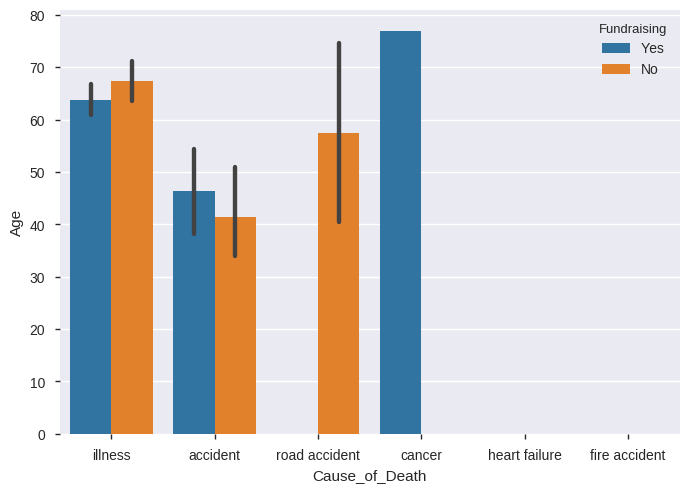

In [61]:
sns.barplot(x=prepared_df['Cause_of_Death'], y=prepared_df['Age'], hue=prepared_df['Fundraising'])

In [62]:
prepared_df['Cause_of_Death'].value_counts()

illness          738
accident          46
road accident      8
cancer             4
fire accident      1
heart failure      1
Name: Cause_of_Death, dtype: int64

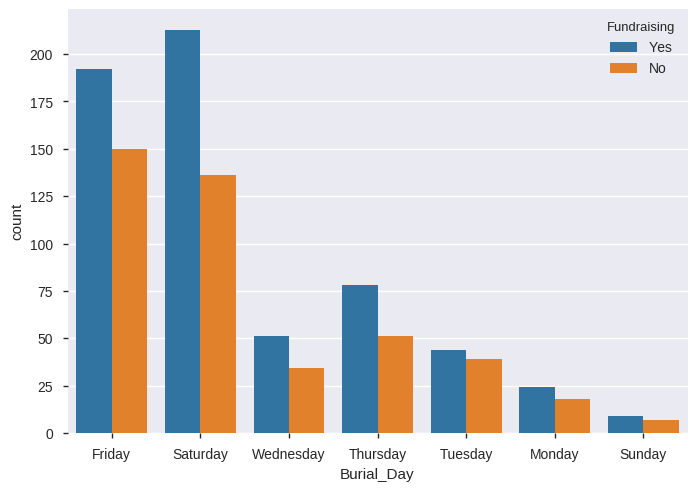

In [63]:
sns.countplot(x=prepared_df['Burial_Day'], hue=prepared_df['Fundraising'])

In [64]:
prepared_df['Color'].unique()

array(['Yes', 'No', nan], dtype=object)

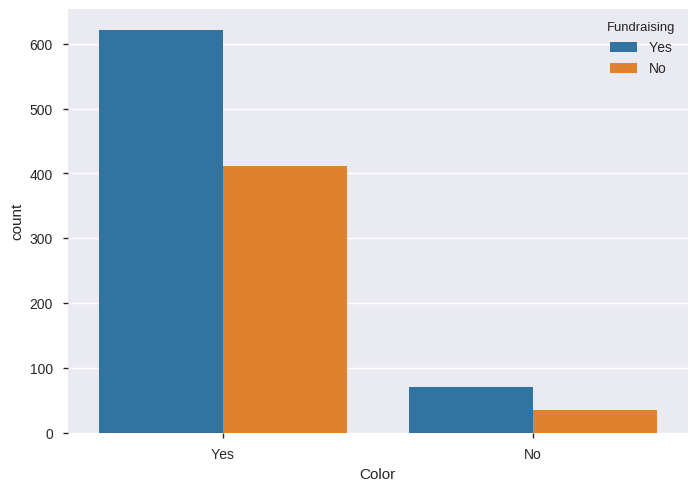

In [65]:
sns.countplot(x=prepared_df['Color'], hue=prepared_df['Fundraising'])

Text(0.5, 1.0, 'Frequency of Ages')

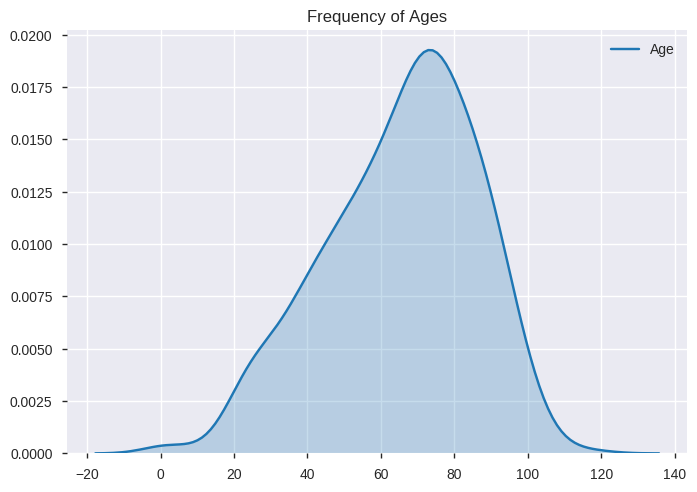

In [66]:
sns.kdeplot(prepared_df['Age'], shade=True)
plt.title('Frequency of Ages')

In [67]:
pp.ProfileReport(prepared_df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,31
Number of observations,1291
Total Missing (%),25.9%
Total size in memory,312.8 KiB
Average record size in memory,248.1 B
Numeric,12
Categorical,16
Boolean,0
Date,3
Text (Unique),0
Rejected,0


# Kaplan-Meier Survival Analysis

In [68]:
kmf_df = prepared_df.copy()

kmf_df['Observed_Announce'] = np.where(kmf_df['Announcement'] != np.nan, True, False)

kmf_df = kmf_df.dropna(axis=0, subset=['Age'])

kmf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 1290
Data columns (total 32 columns):
Name                     507 non-null object
Announcement             493 non-null datetime64[ns]
Death                    413 non-null datetime64[ns]
Burial                   484 non-null datetime64[ns]
Burial_Day               484 non-null object
Burial_Week              484 non-null object
Gender                   507 non-null object
Age                      507 non-null float64
Color                    506 non-null object
Size                     486 non-null float64
Word_Count               487 non-null float64
No_of_Children           457 non-null float64
Significant_Children     456 non-null float64
Significant_Relatives    452 non-null float64
Fundraising              455 non-null object
Death_to_Announce        400 non-null float64
Death_to_Burial          393 non-null float64
Announce_to_Burial       471 non-null float64
No_of_Relatives          443 non-null float64
Count

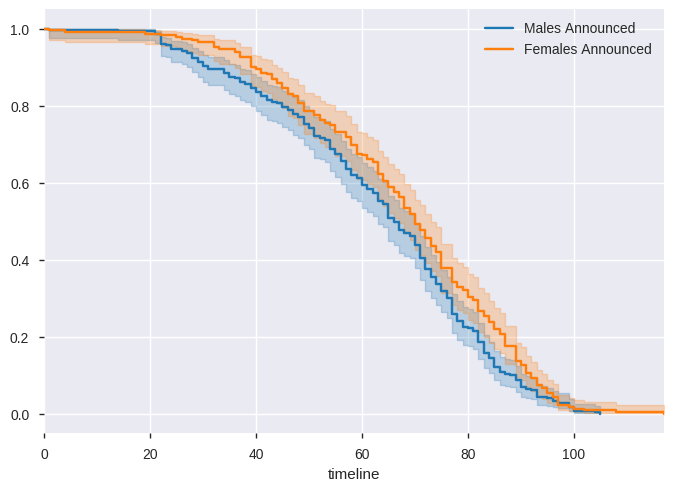

In [69]:
# KMF for Gender

kmfgenders = KaplanMeierFitter()

genderkmf_df = kmf_df.copy()

male = genderkmf_df[genderkmf_df['Gender'] == 'Male']
female = genderkmf_df[genderkmf_df['Gender'] == 'Female']

# fit model for male
kmfgenders.fit(male['Age'], male['Observed_Announce'], label='Males Announced')
maleplot = kmfgenders.plot()

# fit model for female
kmfgenders.fit(female['Age'], female['Observed_Announce'], label='Females Announced')
femaleplot = kmfgenders.plot()

In [70]:
genderkmf_df.isnull().sum()

Name                       0
Announcement              14
Death                     94
Burial                    23
Burial_Day                23
Burial_Week               23
Gender                     0
Age                        0
Color                      1
Size                      21
Word_Count                20
No_of_Children            50
Significant_Children      51
Significant_Relatives     55
Fundraising               52
Death_to_Announce        107
Death_to_Burial          114
Announce_to_Burial        36
No_of_Relatives           64
County_Burial             70
County_Death             290
County_Morgue            136
Distance_Death           304
Distance_Morgue          140
Cause_of_Death           176
Married                   63
Spouse_Alive             106
Spouse_gender            110
Hospital                 399
Morgue                   144
Same_Morgue              422
Observed_Announce          0
dtype: int64

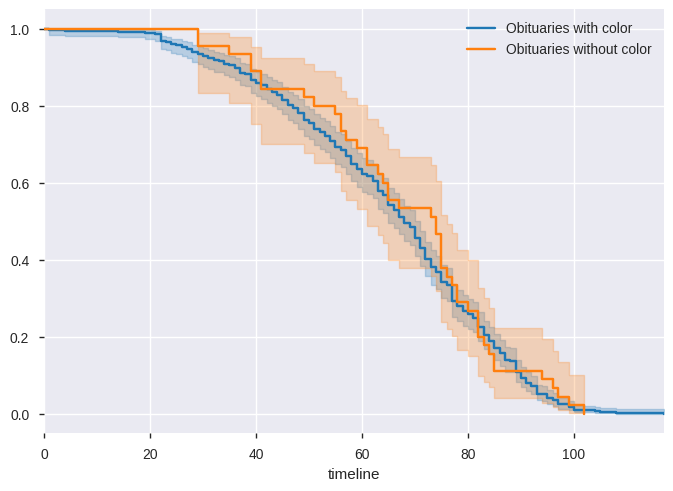

In [71]:
# KMF for Color

kmf = KaplanMeierFitter()

colorkmf_df = kmf_df.copy()

yes_color = colorkmf_df[colorkmf_df['Color'] == 'Yes']
no_color = colorkmf_df[colorkmf_df['Color'] == 'No']

# fit model for male
kmf.fit(yes_color['Age'], yes_color['Observed_Announce'], label='Obituaries with color')
kmf.plot()

# fit model for female
kmf.fit(no_color['Age'], no_color['Observed_Announce'], label='Obituaries without color')
kmf.plot()

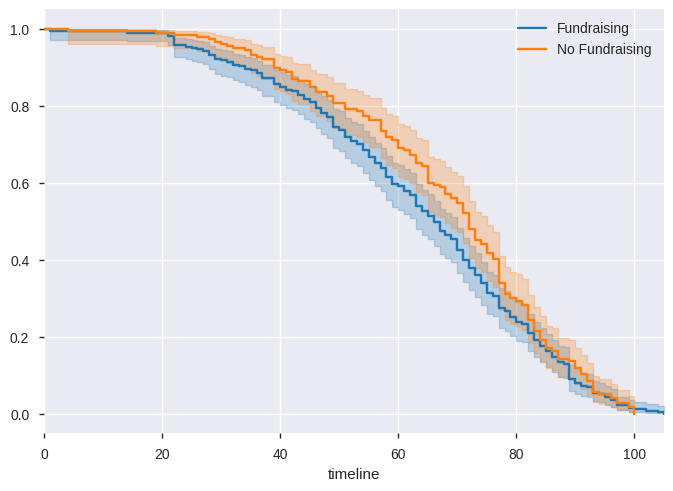

In [72]:
# KMF for Fundraising

kmf = KaplanMeierFitter()

fundkmf_df = kmf_df.copy()

yes_fund = fundkmf_df[fundkmf_df['Fundraising'] == 'Yes']
no_fund = fundkmf_df[fundkmf_df['Fundraising'] == 'No']

# fit model for yes fundraising
kmf.fit(yes_fund['Age'], yes_fund['Observed_Announce'], label='Fundraising')
kmf.plot()

# fit model for no fundraising
kmf.fit(no_fund['Age'], no_fund['Observed_Announce'], label='No Fundraising')
kmf.plot()

In [73]:
kmf_df['Spouse_Alive'].value_counts()

Yes     264
No      134
None      3
Name: Spouse_Alive, dtype: int64

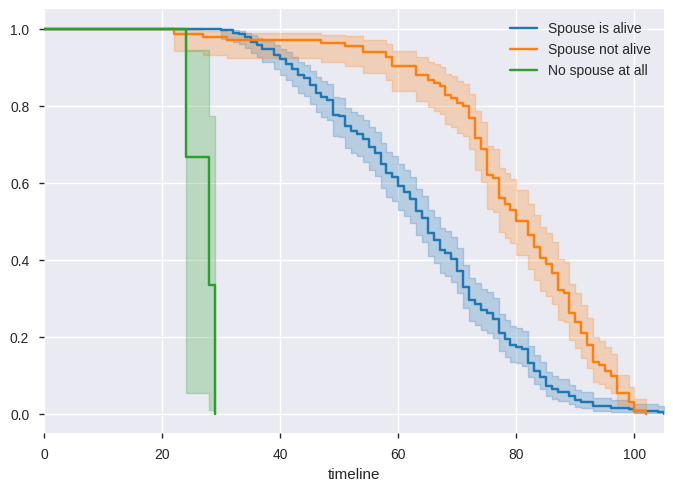

In [74]:
# KMF for Spouse Alive

kmf = KaplanMeierFitter()

spousealivekmf_df = kmf_df.copy()

yes_spouse = spousealivekmf_df[spousealivekmf_df['Spouse_Alive'] == 'Yes']
no_spouse = spousealivekmf_df[spousealivekmf_df['Spouse_Alive'] == 'No']
none_spouse = spousealivekmf_df[spousealivekmf_df['Spouse_Alive'] == 'None']

# fit model for male
kmf.fit(yes_spouse['Age'], yes_spouse['Observed_Announce'], label='Spouse is alive')
kmf.plot()

# fit model for female
kmf.fit(no_spouse['Age'], no_spouse['Observed_Announce'], label='Spouse not alive')
kmf.plot()

kmf.fit(none_spouse['Age'], none_spouse['Observed_Announce'], label='No spouse at all')
kmf.plot()

In [75]:
kmf_df['Spouse_gender'].value_counts()

Female    221
Male      173
None        3
Name: Spouse_gender, dtype: int64

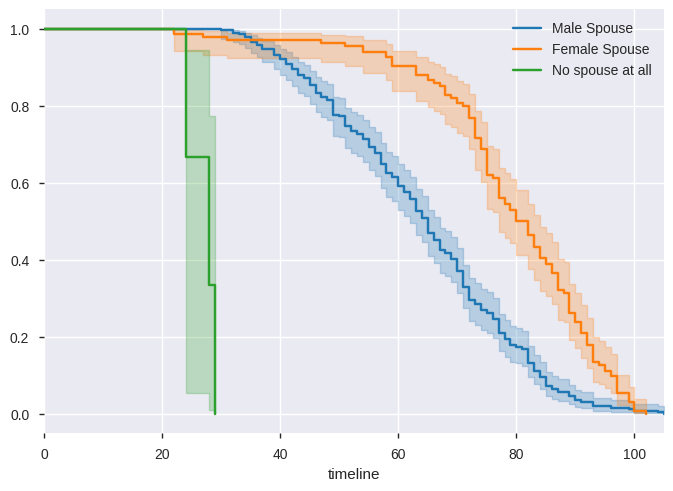

In [76]:
# KMF for Spouse Gender

kmf = KaplanMeierFitter()

spousegenderkmf_df = kmf_df.copy()

male_spouse = spousegenderkmf_df[spousegenderkmf_df['Spouse_Alive'] == 'Yes']
female_spouse = spousegenderkmf_df[spousegenderkmf_df['Spouse_Alive'] == 'No']
none_spouse = spousegenderkmf_df[spousegenderkmf_df['Spouse_Alive'] == 'None']

# fit model for male
kmf.fit(male_spouse['Age'], male_spouse['Observed_Announce'], label='Male Spouse')
kmf.plot()

# fit model for female
kmf.fit(female_spouse['Age'], female_spouse['Observed_Announce'], label='Female Spouse')
kmf.plot()

kmf.fit(none_spouse['Age'], none_spouse['Observed_Announce'], label='No spouse at all')
kmf.plot()

# Dealing with Null Values

# Feature Engineering

In [77]:
prepared_df.head()

,Name,Announcement,Death,Burial,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Fundraising,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Distance_Death,Distance_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue,Same_Morgue
0,Eng. Paul Chemweno,2017-11-08,2017-11-02,2017-11-17,Friday,Weekday,Male,66.0,Yes,55.18,179.0,7.0,0.0,0.0,Yes,6.0,15.0,9.0,35.0,Uasin Gishu,Uasin Gishu,Uasin Gishu,0.0,0.0,illness,Yes,Yes,Female,Memorial Hospital Eldoret,MTRH Eldoret,No
1,Edith Kiende Kiogora,2017-11-08,2017-10-27,2017-11-11,Saturday,Weekend,Female,43.0,Yes,83.60,293.0,4.0,0.0,7.0,Yes,12.0,15.0,3.0,8.0,Tharaka Nithi,Nairobi,Tharaka Nithi,224.0,0.0,illness,Yes,Yes,Male,Nairobi West Hospital,Chogoria Hospital Mortuary,No
2,Simon Muchiri Ngigii Mbaria,2017-11-08,2017-11-01,2017-11-08,Wednesday,Weekday,Male,35.0,Yes,109.12,206.0,4.0,0.0,2.0,No,7.0,7.0,0.0,7.0,Nyandarua,Nyandarua,Nakuru,0.0,77.0,illness,Yes,Yes,Female,Charity Hospital Nyahururu,Umash Nakuru,No
3,Mwalimu Erick Namusasi Werunga,2017-11-08,2017-10-24,2017-11-09,Thursday,Weekday,Male,54.0,Yes,83.60,171.0,4.0,0.0,0.0,No,15.0,16.0,1.0,33.0,Trans Nzioa,NaN,Trans Nzioa,0.0,NaN,illness,Yes,No,Female,NaN,Maida Mortuary,NaN
4,Catherine Mueni Sina,2017-11-08,2017-11-02,2017-11-11,Saturday,Weekend,Female,41.0,No,55.18,150.0,1.0,0.0,NaN,NaN,6.0,9.0,3.0,17.0,Machakos,Uasin Gishu,NaN,378.0,NaN,accident,NaN,NaN,Male,NaN,NaN,NaN


In [80]:
def extract_date(df, column):
  df[column+'_day'] = df[column].apply(lambda x: x.day)
  df[column+'_month'] = df[column].apply(lambda x: x.month)
  df[column+'_year'] = df[column].apply(lambda x: x.year)

extract_date(prepared_df, 'Announcement')
extract_date(prepared_df, 'Death')
extract_date(prepared_df, 'Burial')
prepared_df.sample(5)

,Name,Announcement,Death,Burial,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Fundraising,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Distance_Death,Distance_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue,Same_Morgue,Announcement_day,Announcement_month,Announcement_year,Death_day,Death_month,Death_year,Burial_day,Burial_month,Burial_year
273,Walter Githitu Muhu,2017-05-23,NaT,2017-05-25,Thursday,Weekday,Male,NaN,Yes,56.07,204.0,4.0,1.0,3.0,Yes,NaN,NaN,2.0,15.0,Kiambu,NaN,Nairobi,NaN,32.0,illness,Yes,Yes,Female,NaN,Kenyatta University,No,23.0,5.0,2017.0,NaN,NaN,NaN,25.0,5.0,2017.0
919,Joshua Mutua,2017-05-10,2017-04-05,2017-05-13,Saturday,Weekend,Male,83.0,Yes,84.48,373.0,5.0,0.0,17.0,Yes,35.0,38.0,3.0,3.0,Machakos,NaN,Machakos,NaN,0.0,NaN,yes,Yes,Female,NaN,Montezuma funeral home Machakos,NaN,10.0,5.0,2017.0,5.0,4.0,2017.0,13.0,5.0,2017.0
222,Alexander Macharia Kagunyu,2017-11-13,2017-11-07,2017-11-15,Wednesday,Weekday,Male,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,6.0,8.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,11.0,2017.0,7.0,11.0,2017.0,15.0,11.0,2017.0
635,Fortunata Njoki,2017-02-24,2017-02-20,2017-02-28,Tuesday,Weekday,Female,NaN,Yes,68.53,218.0,6.0,0.0,0.0,No,4.0,8.0,4.0,7.0,Nyeri,NaN,Nyeri,NaN,0.0,illness,Yes,Yes,Male,NaN,Nyeri Funeral Home,NaN,24.0,2.0,2017.0,20.0,2.0,2017.0,28.0,2.0,2017.0
65,Anthony Kipyegon Kipsang,2017-10-31,2017-10-21,2017-11-04,Saturday,Weekend,Male,28.0,Yes,145.96,194.0,0.0,0.0,0.0,Yes,10.0,14.0,4.0,67.0,Baringo,Nakuru,Nakuru,40.0,40.0,accident,No,None,None,NaN,Umash Nairobi,No,31.0,10.0,2017.0,21.0,10.0,2017.0,4.0,11.0,2017.0


# Feature Selection

In [82]:
prepared_df.shape

(1291, 40)